In [1]:
import torch

from abc import ABC, abstractmethod
from typing import List, Tuple, Dict, Optional
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from unidecode import unidecode

import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- BASE ---
class Module(ABC):
    @abstractmethod
    def forward(x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError  
    
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return self.forward(x)

    @property
    def out(self) -> torch.Tensor:
        return self._out

    @property
    def parameters(self) -> List[torch.Tensor]:
        return []

# --- LINEAR LAYER ---

class Linear(Module):
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        self._weight = torch.randn(fan_in, fan_out) / fan_in**0.5
        self._bias = torch.zeros(fan_out) if bias else None

    @property
    def weight(self) -> torch.Tensor:
        return self._weight

    @weight.setter
    def weight(self, x: torch.Tensor) -> None:
        self._weight = x
    
    @property
    def bias(self) -> torch.Tensor:
        return self._bias

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # hprebn = embcat @ W1 + b1 # hidden layer pre-activation
        self._out = x @ self._weight
        if self._bias is not None:
            self._out += self.bias
        return self._out

    @property
    def parameters(self) -> List[torch.Tensor]:
        return [self.weight] + ([self.bias] if self.bias is not None else [])


# --- ACTIVATION ---

class Tanh(Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._out = torch.tanh(x)
        return self._out

class ReLU(Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._out = torch.relu(x)
        return self._out

# --- BATCH NORM ---


class BatchNorm1d(Module):
    def __init__(self, fan_in: int, eps: float = 1e-5, momentum: float = 1e-1) -> None:
        self._eps = eps
        self._momentum = momentum
        self._training = True
        # parameters
        self._gamma = torch.ones(fan_in)
        self._beta = torch.zeros(fan_in)
        # buffers
        self._running_mean = torch.zeros(fan_in)
        self._running_var = torch.ones(fan_in)
    
    @property
    def training(self) -> bool:
        return self._training

    @training.setter
    def training(self, value: bool) -> None:
        self._training = value

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        print(x.shape)
        if self._training:
            if x.dim == 2:
                dim = 0
            elif x.dim == 3:
                dim = (0, 1)
            xmean = x.mean(dim=dim, keepdim=True)
            xvar = x.var(dim=dim, keepdim=True)
        else:
            xmean = self._running_mean
            xvar = self._running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self._eps)
        self._out = self._gamma * xhat + self._beta

        # updating buffers 
        if self._training:
            self._running_mean = self._momentum * xmean + (1 - self._momentum) * self._running_mean
            self._running_var = self._momentum * xvar + (1 - self._momentum) * self._running_var

        return self._out

    @property
    def parameters(self) -> List[torch.Tensor]:
        return [self._gamma, self._beta]

# --- EMBEDDING ---

class Embedding(Module):
    def __init__(self, vocab_size: int, embedding_size: int) -> None:
        self._embedding = torch.randn(vocab_size, embedding_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._out = self._embedding[x]
        return self._out

    @property
    def parameters(self) -> List[torch.Tensor]:
        return [self._embedding]
    
# --- FLATTEN ---
class Flatten(Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._out = x.view(x.shape[0], -1)
        return self._out
    
class FlattenConsecutive(Module):
    def __init__(self, n: int = 1) -> None:
        self._n = n

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape
        x = x.view(B, T // self._n, C * self._n)
        if x.shape[1] == 1:
            x = x.squeeze(1)

        self._out = x
        return self._out


# --- SEQUENTIAL ---
class Sequential(Module):
    def __init__(self, *layers: Module) -> None:
        self._layers = list(layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self._layers:
            x = layer(x)
        self._out = x
        return x

    @property
    def layers(self) -> List[Module]:
        return self._layers
    
    @property
    def out_features(self) -> int:
        return self._layers[-1].weight.shape[-1]

    @property
    def parameters(self) -> List[torch.Tensor]:
        return [p for layer in self._layers for p in layer.parameters]

In [3]:
class LithuanianNamesDataset(Dataset):
    def __init__(self, names: Optional[List[str]] = None, normalised: bool = True) -> None:
        self._normalised = normalised
        if names is None:
            self._names = self._get_names()
        else:
            self._names = names

    def _get_names(self) -> List[str]:
        page_content = self._get_page_content()
        names = self._extract_names(page_content)
        return names
    
    @property
    def raw_data(self) -> List[str]:
        return self._names

    def __len__(self) -> int:
        return len(self._names)

    def __getitem__(self, idx: int) -> str:
        return self._names[idx]

    def _get_page_content(self) -> BeautifulSoup:
        resp = requests.get("http://vardai.vlkk.lt/dazninis-rekomenduojamu-vardu-sarasas-baltiskos-kilmes-vardai/")
        return BeautifulSoup(resp.text, "html.parser")
    
    def _extract_names(self, page_content: BeautifulSoup) -> List[str]:
        main_content = page_content.find("main")
        ps = main_content.find_all("p")
        names = [p.text.lower() for p in ps if len(p.text.split()) == 1]
        names = [name for name in names if name.isalpha()]
        if self._normalised:
            return [unidecode(name) for name in names]
        return names


In [4]:
class WordsInBlocksDataset(Dataset):
    def __init__(self, x: torch.Tensor, y: torch.Tensor) -> None:
        self._x = x
        self._y = y

    def __len__(self) -> int:
        return self._x.shape[0]
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self._x[idx], self._y[idx]

In [5]:
class NamesModel:
    def __init__(self, encoder: Module, class_num) -> None:
        self._encoder = encoder
        self._classifier = Linear(encoder.out_features, class_num)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self._encoder(x)
        x = self._classifier(x)
        return x

    def freeze(self) -> None:
        for p in self._encoder.parameters:
            p.requires_grad = False
    
    def unfreeze(self) -> None:
        for p in self.parameters:
            p.requires_grad = True
    
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return self.forward(x)
    
    @property
    def parameters(self) -> List[torch.Tensor]:
        return self._encoder.parameters + self._classifier.parameters

In [6]:
def build_dataset(
    words: List[str], stoi: Dict[str, int], block_size: int = 3
) -> Tuple[torch.Tensor, torch.Tensor]:
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

## Training on lit names

In [7]:
dataset = LithuanianNamesDataset(normalised=True)

In [8]:
for i, name in enumerate(dataset):
    if i > 10:
        break
    print(name)

aida
aidas
aiste
aistis
alanta
aldas
aldona
aldonas
algimantas
algimante
algimanta


In [9]:
dataset = LithuanianNamesDataset(normalised=True).raw_data

In [10]:
# read in all the words
words = requests.get(
    "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
).text.splitlines()


# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [11]:
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

In [12]:
BLOCK_SIZE = 8
EMB_SIZE = 10

In [13]:
Xtr, Ytr = build_dataset(train_data, stoi=stoi, block_size=BLOCK_SIZE)
Xtest, Ytest = build_dataset(test_data, stoi=stoi, block_size=BLOCK_SIZE)

torch.Size([7528, 8]) torch.Size([7528])
torch.Size([1858, 8]) torch.Size([1858])


In [14]:
lt_model = NamesModel(
    Sequential(
        Embedding(vocab_size, EMB_SIZE),
        Flatten(),
        Linear(EMB_SIZE * BLOCK_SIZE, 128),
        ReLU(),
        Linear(128, 64),
        ReLU(),
        Linear(64, 64),
    ),
    class_num=vocab_size,
)

In [15]:
train_dataloader = DataLoader(WordsInBlocksDataset(Xtr, Ytr), batch_size=32, shuffle=True)
test_dataloader = DataLoader(WordsInBlocksDataset(Xtest, Ytest), batch_size=32, shuffle=False)

In [16]:
epochs = 150
lr = 0.01

lossi: List[float] = []

lt_model.unfreeze()

for i in range(epochs):
    epoch_loss: float = []
    for batch in train_dataloader:
        x, y = batch
        y_pred = lt_model(x)
        loss = F.cross_entropy(y_pred, y)

        for p in lt_model.parameters:
            p.grad = None

        loss.backward()

        for p in lt_model.parameters:
            p.data -= lr * p.grad

        epoch_loss.append(loss.item())
        lossi.append(loss.item())
    
    if i % 2 == 0:
        print(f"Epoch: {i}, Loss: {sum(epoch_loss) / len(epoch_loss)}")

Epoch: 0, Loss: 2.775640602839195
Epoch: 2, Loss: 2.1298937241909868
Epoch: 4, Loss: 1.8905468042624198
Epoch: 6, Loss: 1.7547833126480297
Epoch: 8, Loss: 1.662248171487097
Epoch: 10, Loss: 1.5904444771803032
Epoch: 12, Loss: 1.5381627769793493
Epoch: 14, Loss: 1.4941373136589082
Epoch: 16, Loss: 1.4592633310516
Epoch: 18, Loss: 1.4306328955848338
Epoch: 20, Loss: 1.4015117982181453
Epoch: 22, Loss: 1.3808494993185594
Epoch: 24, Loss: 1.3600313782186833
Epoch: 26, Loss: 1.3390635421215478
Epoch: 28, Loss: 1.3168639914464142
Epoch: 30, Loss: 1.3003182257130994
Epoch: 32, Loss: 1.2855746306605258
Epoch: 34, Loss: 1.2652379211227773
Epoch: 36, Loss: 1.2502725250640159
Epoch: 38, Loss: 1.2363766121157145
Epoch: 40, Loss: 1.2261915555444813
Epoch: 42, Loss: 1.213995211710364
Epoch: 44, Loss: 1.1992685529640166
Epoch: 46, Loss: 1.1893933183055814
Epoch: 48, Loss: 1.1769080826286542
Epoch: 50, Loss: 1.1644134296704147
Epoch: 52, Loss: 1.1577720177375663
Epoch: 54, Loss: 1.147551818040468
Epoc

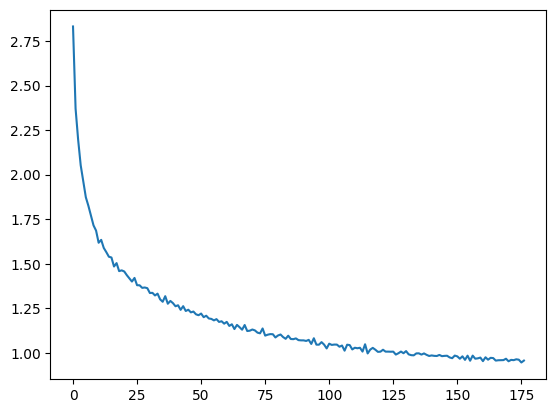

In [17]:
smoothing_gain = 200
plt.plot(torch.tensor(lossi).view(-1, smoothing_gain).mean(dim=1))

In [19]:
j = 0
while j < 20:
    
    out = []
    context = [0] * BLOCK_SIZE
    while True:
      logits = lt_model.forward(torch.tensor(context).view(1, -1))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    name = ''.join(itos[i] for i in out)
    print(name)
    j += 1

zadrius.
jovaldas.
svygaudas.
eimante.
butvydas.
gilma.
daugvydas.
urmina.
velgirdas.
gora.
liaulas.
rmina.
norgaile.
augute.
rimante.
junvile.
rugile.
gilminte.
saugirda.
sangaudas.


## Training on eng names

In [52]:
train_data, test_data = train_test_split(words, test_size=0.2, random_state=42)

In [53]:
Xtr, Ytr = build_dataset(train_data, stoi=stoi, block_size=BLOCK_SIZE)
Xtest, Ytest = build_dataset(test_data, stoi=stoi, block_size=BLOCK_SIZE)

torch.Size([182497, 8]) torch.Size([182497])
torch.Size([45649, 8]) torch.Size([45649])


In [56]:
train_dataloader = DataLoader(WordsInBlocksDataset(Xtr, Ytr), batch_size=32, shuffle=True)
test_dataloader = DataLoader(WordsInBlocksDataset(Xtest, Ytest), batch_size=32, shuffle=False)

In [57]:
en_model = NamesModel(
    Sequential(
        Embedding(vocab_size, EMB_SIZE),
        Flatten(),
        Linear(EMB_SIZE * BLOCK_SIZE, 128),
        ReLU(),
        Linear(128, 64),
        ReLU(),
        Linear(64, 64),
    ),
    class_num=vocab_size,
)

In [58]:
epochs = 15
lr = 0.01

lossi: List[float] = []

en_model.unfreeze()

for i in range(epochs):
    epoch_loss: float = []
    for batch in train_dataloader:
        x, y = batch
        y_pred = en_model(x)
        loss = F.cross_entropy(y_pred, y)

        for p in en_model.parameters:
            p.grad = None

        loss.backward()

        for p in en_model.parameters:
            p.data -= lr * p.grad

        epoch_loss.append(loss.item())
        lossi.append(loss.item())
    
    if i % 2 == 0:
        print(f"Epoch: {i}, Loss: {sum(epoch_loss) / len(epoch_loss)}")

Epoch: 0, Loss: 2.4593536910427236
Epoch: 2, Loss: 2.227836358889958
Epoch: 4, Loss: 2.170639691333617
Epoch: 6, Loss: 2.1367630815397307
Epoch: 8, Loss: 2.111568640086795
Epoch: 10, Loss: 2.090723270892595
Epoch: 12, Loss: 2.0733176430825764
Epoch: 14, Loss: 2.0595395646957995


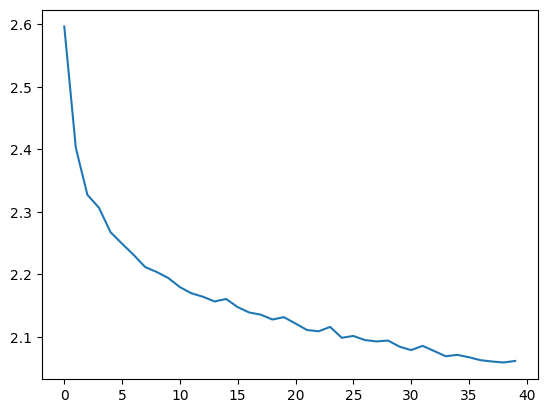

In [59]:
smoothing_gain = 2139
plt.plot(torch.tensor(lossi).view(-1, smoothing_gain).mean(dim=1))

In [60]:
j = 0
while j < 20:
    
    out = []
    context = [0] * BLOCK_SIZE
    while True:
      logits = en_model.forward(torch.tensor(context).view(1, -1))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    name = ''.join(itos[i] for i in out)
    print(name)
    j += 1

uovine.
esshria.
iatana.
haskni.
aura.
amani.
nailyn.
arick.
etmain.
annovi.
kaidy.
yamir.
aurim.
yaylee.
alan.
naoko.
courland.
shan.
anperaa.
yuris.


## Training with transfer learning

In [61]:
lt_model_tl = en_model

In [62]:
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

Xtr, Ytr = build_dataset(train_data, stoi=stoi, block_size=BLOCK_SIZE)
Xtest, Ytest = build_dataset(test_data, stoi=stoi, block_size=BLOCK_SIZE)

train_dataloader = DataLoader(WordsInBlocksDataset(Xtr, Ytr), batch_size=32, shuffle=True)
test_dataloader = DataLoader(WordsInBlocksDataset(Xtest, Ytest), batch_size=32, shuffle=False)

torch.Size([7528, 8]) torch.Size([7528])
torch.Size([1858, 8]) torch.Size([1858])


In [67]:
epochs = 150
lr = 0.01

lossi: List[float] = []

lt_model_tl.freeze()

for i in range(epochs):
    epoch_loss: float = []
    for batch in train_dataloader:
        x, y = batch
        y_pred = lt_model_tl(x)
        loss = F.cross_entropy(y_pred, y)

        for p in lt_model_tl.parameters:
            p.grad = None

        loss.backward()

        for p in lt_model_tl.parameters:
            if p.requires_grad:
                p.data -= lr * p.grad

        epoch_loss.append(loss.item())
        lossi.append(loss.item())
    
    if i % 2 == 0:
        print(f"Epoch: {i}, Loss: {sum(epoch_loss) / len(epoch_loss)}")

Epoch: 0, Loss: 1.5454645040681807
Epoch: 2, Loss: 1.542299481014074
Epoch: 4, Loss: 1.5442570639868913
Epoch: 6, Loss: 1.5460564039521298
Epoch: 8, Loss: 1.540294148659302
Epoch: 10, Loss: 1.5416106758481365
Epoch: 12, Loss: 1.5420236880496396
Epoch: 14, Loss: 1.5391446862180354
Epoch: 16, Loss: 1.5383278500225583
Epoch: 18, Loss: 1.5413914325378708
Epoch: 20, Loss: 1.5362844398971331
Epoch: 22, Loss: 1.539646248443652
Epoch: 24, Loss: 1.5349975791523012
Epoch: 26, Loss: 1.533651006928945
Epoch: 28, Loss: 1.5340760431047213
Epoch: 30, Loss: 1.5344991289963157
Epoch: 32, Loss: 1.5357574411367967
Epoch: 34, Loss: 1.5335904450739843
Epoch: 36, Loss: 1.5323263091050972
Epoch: 38, Loss: 1.531657295206846
Epoch: 40, Loss: 1.528992571568085
Epoch: 42, Loss: 1.5337108318078316
Epoch: 44, Loss: 1.5296396860631847
Epoch: 46, Loss: 1.528330903184616
Epoch: 48, Loss: 1.5285023304365448
Epoch: 50, Loss: 1.5307680994777355
Epoch: 52, Loss: 1.5288070253396437
Epoch: 54, Loss: 1.5269251758769407
Epoc

In [68]:
j = 0
while j < 20:
    
    out = []
    context = [0] * BLOCK_SIZE
    while True:
      logits = lt_model_tl.forward(torch.tensor(context).view(1, -1))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    name = ''.join(itos[i] for i in out)
    print(name)
    j += 1

jorigus.
vijante.
tiris.
danganduu.
ramgedgudas.
gorda.
veigedra.
noris.
kairis.
autvydantas.
ganeris.
las.
vajanve.
vingarde.
etelim.
nide.
minautailas.
gir.
dangarte.
namvim.


### Fine-tuning the model

In [72]:
epochs = 150
lr = 0.001

lossi: List[float] = []

lt_model_tl.unfreeze()

for i in range(epochs):
    epoch_loss: float = []
    for batch in train_dataloader:
        x, y = batch
        y_pred = lt_model_tl(x)
        loss = F.cross_entropy(y_pred, y)

        for p in lt_model_tl.parameters:
            p.grad = None

        loss.backward()

        for p in lt_model_tl.parameters:
            if p.requires_grad:
                p.data -= lr * p.grad

        epoch_loss.append(loss.item())
        lossi.append(loss.item())
    
    if i % 2 == 0:
        print(f"Epoch: {i}, Loss: {sum(epoch_loss) / len(epoch_loss)}")

Epoch: 0, Loss: 0.9492278068752612
Epoch: 2, Loss: 0.9480608396105847
Epoch: 4, Loss: 0.949660604030399
Epoch: 6, Loss: 0.947899864134142
Epoch: 8, Loss: 0.9485407815141192
Epoch: 10, Loss: 0.9449206229488728
Epoch: 12, Loss: 0.945444671405574
Epoch: 14, Loss: 0.9439779941813421
Epoch: 16, Loss: 0.9456464408312814
Epoch: 18, Loss: 0.9431084987975783
Epoch: 20, Loss: 0.9427872598171234
Epoch: 22, Loss: 0.9416486446635198
Epoch: 24, Loss: 0.9428796962661258
Epoch: 26, Loss: 0.9418303227778209
Epoch: 28, Loss: 0.9398620094535715
Epoch: 30, Loss: 0.9396099222161002
Epoch: 32, Loss: 0.9401789835448993
Epoch: 34, Loss: 0.9384640556270794
Epoch: 36, Loss: 0.9373222525089474
Epoch: 38, Loss: 0.9396082546751378
Epoch: 40, Loss: 0.9372914401909053
Epoch: 42, Loss: 0.9361404486126819
Epoch: 44, Loss: 0.9378458118792308
Epoch: 46, Loss: 0.9353532505742574
Epoch: 48, Loss: 0.9357646792116812
Epoch: 50, Loss: 0.9352058567485567
Epoch: 52, Loss: 0.9341920140688702
Epoch: 54, Loss: 0.9334994688377543


In [73]:
j = 0
while j < 20:
    
    out = []
    context = [0] * BLOCK_SIZE
    while True:
      logits = lt_model_tl.forward(torch.tensor(context).view(1, -1))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    name = ''.join(itos[i] for i in out)
    print(name)
    j += 1

vidutis.
mantrimas.
eitara.
vantautas.
vidmina.
ramune.
vydene.
eimas.
tolvydas.
eile.
alminta.
kesmina.
nakute.
augmonas.
vygirde.
sanrius.
laimona.
daugintas.
gailimante.
geisvinas.
